In [65]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky, powspec
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils, gan, transforms
from cosmikyu import nn as cnn
import os
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random
from itertools import cycle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


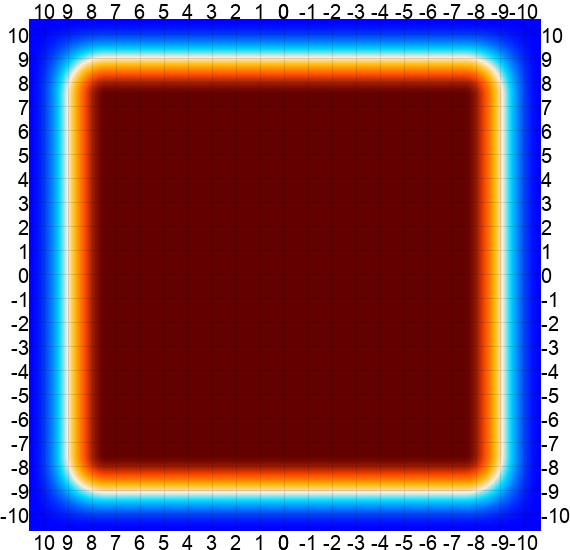

In [66]:
nside = 20
nbatch = nside*nside ## it goes like nbatch**2

shape = (128, 128)
bshape = (shape[0]*nside,shape[1]*nside)
_, bwcs = omaps.rect_geometry(width_arcmin=0.5*shape[0]*nside, px_res_arcmin=0.5)
cuda = False

def get_template(shape, wcs):
    return enmap.zeros(shape, wcs)

def get_mask(taper_percent=15.):
    taper, _ = omaps.get_taper(bshape, bwcs, taper_percent=taper_percent, pad_percent=0.)
    loc = taper == 0
    taper[loc] = np.min(taper[~loc])
    return taper

mask = get_mask()
enplot.pshow(mask, downgrade=5)

In [67]:
bin_edges = np.linspace(0,10000., 50)
lmax=10000
l = np.arange(lmax+1)
beam_fwhm = 0.9
beam_fwhm = np.deg2rad(beam_fwhm/60.)
sigma     = beam_fwhm/(2.*np.sqrt(2.*np.log(2)))
def get_f_ell(l):
    f_ell = np.exp(-(l)**2.*sigma**2./2)
    return l, f_ell
#transfer = list(get_f_ell(l))
transfer = None
PITAS = power.PITAS("151020_{}x{}_0.9deconv_notrans".format(bshape[0],bshape[1]), mask, mask, bin_edges=bin_edges, lmax=lmax, transfer=transfer)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans/curved_full_CLTT_inv.dat
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans/curved_full_CLTP_inv.dat
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans/curved_full_CLPP_inv.dat
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans/curved_full_DLTT_inv.dat
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans/curved_full_DLTP_inv.dat
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans/curved_full_DLPP_inv.dat
[get_bbl] mcm directory: /home/dwhan89/workspace/pitas/pitas/../output/151020_2560x2560_0.9deconv_notrans
trying to load /home/dwhan89/workspace/pitas/pitas/../output/151020_2560

In [68]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
stat_dir = os.path.join(sehgal_dir, "stats")
SDS_test = datasets.SehgalDataSet(sehgal_dir, "test281220_fromcat", transforms=[],
                                  dummy_label=False, dtype=np.float64,shape=(5,)+shape)

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

In [69]:

#STAT_TEST = stats.STATS("201020_test_specs_deconv", output_dir=stat_dir, overwrite=False)
#STAT_TEST = stats.STATS("131120_test_specs_deconv", output_dir=stat_dir, overwrite=False)
STAT_TEST = stats.STATS("281220_test_specs_deconv", output_dir=stat_dir, overwrite=False)
def get_data(wcs=bwcs, nside=nside, dataset=SDS_test, taper=True):
    data = SDS_test[0].copy()
    nx, ny = shape
    nshape = (data.shape[0], nx*nside, ny*nside)
    temp = enmap.zeros(nshape, wcs)
    for i in range(nside):
        for j in range(nside):
            cidx = random.randint(0, len(SDS_test)-1)
            sx = i*nx
            sy = j*ny
            temp[:,sy:sy+ny,sx:sx+nx] = SDS_test[cidx][...]
    if taper:
        temp[...] *= get_mask()
    return temp


lmax = 10000
overwrite = False
compts = ["kappa", "ksz", "tsz", "ir", "rad"]
subtasks = [10,20,30,40,50,60,5,35,45,25]#np.arange(10, dtype=np.int)
for sim_idx in subtasks:
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    print("processing sim {}".format(sim_idx))
    if STAT_TEST.has_data("dls_radxrad", sim_idx):
        continue
    emap = get_data()

    alms = {}
    for i, compt_idx in enumerate(compts):
        #print(i, compt_idx)
        alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
    del compt_idx

    for compt_idx1, compt_idx2 in product(compts, compts):
        compt_keys = [compt_idx1, compt_idx2]
        compt_keys.sort()
        stat_key = "dls_{}x{}".format(compt_keys[0], compt_keys[1])
        if STAT_TEST.has_data(stat_key, sim_idx):
            continue
        else:
            cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
            l = np.arange(len(cl), dtype=np.float)
            dl = l*(l+1.)/(2*np.pi)*cl
            lbin, dlbin = PITAS.binner.bin(l, dl)
            dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
            STAT_TEST.add_data("lbin", 0, lbin)
            STAT_TEST.add_data(stat_key, sim_idx, dlbin)

    #del alms

_ = STAT_TEST.get_stats(save_data=True)

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_281220_test_specs_deconv.npz
processing sim 10
processing sim 20
processing sim 30
processing sim 40
processing sim 50
processing sim 60
processing sim 5
processing sim 35
processing sim 45
processing sim 25
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_281220_test_specs_deconv.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_281220_test_specs_deconv.npz
calculating stats


/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=F

In [70]:

STanh = cnn.ScaledTanh(15., 2./15.)
LF = cnn.LinearFeature(4,4)
SC = transforms.SehgalSubcomponets([0])
experiment_id = "6dd3053687de464aabc4a2bb441e60cf"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_281220/{}/model".format(experiment_id)
print(model_dir)
use_ng = False
if use_ng:
    #GK = datasets.SehgalDataSet(sehgal_dir, "train_secondary161120", 
    #                                transforms=[SC], dummy_label=False, dtype=np.float32)
    GK = datasets.SehgalDataSet(sehgal_dir, "train_secondary281220_fromcat", 
                                    transforms=[SC], dummy_label=False, dtype=np.float32)
    stat_identifier = experiment_id
else:
    GK = datasets.SehgalDataSet(sehgal_dir,"Gkappa281220", transforms=[], dummy_label=False,
                                dtype=np.float64, shape=(1,128,128))
    
    stat_identifier = experiment_id+"G"

#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/281220_logz_normalization_info_validation.npz"
overwrite =False
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=["kappa"])
SDUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
STAT_GEN = stats.STATS(stat_identifier, output_dir=stat_dir, overwrite=overwrite)
save_points = [5,6,9]#np.arange(1,11,1)#np.arange(1,6,1)#[1,2]#[0,5,6,9,10,20]#np.arange(35,36,1)
nsim = 5
dropout_rate = 0
gen_act = [LF, STanh]
#gen_act = [STanh]

for save_point in save_points: 
    compts = ["kappa", "ksz", "tsz", "ir", "rad"]
    PIXGAN = gan.PIXGAN_WGP("sehgal_pixgan_281220", (5,)+shape, nconv_fcgen=64,
                              nconv_fcdis=64, cuda=cuda, ngpu=4, nconv_layer_gen=4, nconv_layer_disc=5, kernal_size=4, stride=2,
                              padding=1, output_padding=0, gen_act=gen_act, nin_channel=1, nout_channel=4, nthresh_layer_gen=3, 
                            nthresh_layer_disc=0, dropout_rate=dropout_rate)
    #PIXGAN.generator.train()


    PIXGAN.load_states(model_dir, "_{}".format(save_point))
    
    def get_generated(wcs=bwcs, nside=nside, gan=PIXGAN, taper=True):
        shape = gan.shape
        nx, ny = shape[1], shape[2]
        nshape = (shape[0], shape[1]*nside, shape[2]*nside)
        temp = enmap.zeros(nshape, wcs)
        np.random.seed(None)
        #generated = gan.generate_samples(nside*nside).data.numpy()
        nrepeat = 1
       
        temp_ctr = 0
        for i in range(nside):
            for j in range(nside):
                cidx = random.randint(0, len(GK)-1)
                sx = i*nx
                sy = j*ny
                ctr = 0
                while(ctr < nrepeat):
                    stamp =  PIXGAN.generate_samples(SDN(GK[cidx]), True, train=False)[0].data.numpy()
                    
                    temp[:,sy:sy+ny,sx:sx+nx] += stamp
                    ctr += 1
                    temp_ctr += 1
        print(np.max(stamp), np.min(stamp))
        temp /= nrepeat
        temp = SDUN(temp)
        if taper:
            temp[...] *= get_mask()
        return temp
    
    subtasks = np.arange(0,nsim, dtype=np.int)
    for sim_idx in subtasks:
        print("processing sim {}".format(sim_idx))
        stat_key = "dls_radxrad_r{}".format(save_point)
 

        if STAT_GEN.has_data(stat_key, sim_idx):
            continue
        emap = get_generated()
        for i in range(0, 5):
            print(np.max(emap[i]))
            #enplot.pshow(emap[i], downgrade=6)

        alms = {}
        for i, compt_idx in enumerate(compts):
            #enplot.pshow(emap[i])
            alms[compt_idx] = curvedsky.map2alm(emap[i], lmax=lmax)
        del compt_idx
        
        for compt_idx1, compt_idx2 in product(compts, compts):
            compt_keys = [compt_idx1, compt_idx2]
            compt_keys.sort()
            stat_key = "dls_{}x{}_r{}".format(compt_keys[0], compt_keys[1],save_point)
            if STAT_GEN.has_data(stat_key, sim_idx):
                continue
            else:
                cl = hp.alm2cl(alms[compt_idx1], alms[compt_idx2])
                l = np.arange(len(cl), dtype=np.float)
                dl = l*(l+1.)/(2*np.pi)*cl
                lbin, dlbin = PITAS.binner.bin(l, dl)
                dlbin = np.dot(PITAS.mcm_dltt_inv, dlbin)
                STAT_GEN.add_data("lbin", 0, lbin)
                STAT_GEN.add_data(stat_key, sim_idx, dlbin)

        #del alms
_ = STAT_GEN.get_stats(save_data=True)

Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_281220/6dd3053687de464aabc4a2bb441e60cf/model
[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6dd3053687de464aabc4a2bb441e60cfG.npz
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


loading saved states _5
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


loading saved states _6
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
loading saved states _9
processing sim 0
processing sim 1
processing sim 2
processing sim 3
processing sim 4
[STATS] collecting data
[STATS] saving /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6dd3053687de464aabc4a2bb441e60cfG.npz from root 0
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_6dd3053687de464aabc4a2bb441e60cfG.npz
calculating stats


In [71]:
for save_point in save_points:
    PIXGAN.load_states(model_dir, "_{}".format(save_point))
    print(PIXGAN.generator.model_dict["final"][-2].weight)
    print(PIXGAN.generator.model_dict["final"][-2].bias)

loading saved states _5
Parameter containing:
tensor([1.0357, 1.0224, 1.1446, 1.8506], requires_grad=True)
Parameter containing:
tensor([ 0.0170, -0.0132,  0.0032, -0.0400], requires_grad=True)
loading saved states _6
Parameter containing:
tensor([1.0213, 1.0142, 1.1403, 1.8353], requires_grad=True)
Parameter containing:
tensor([ 0.0169, -0.0127,  0.0030, -0.0439], requires_grad=True)
loading saved states _9
Parameter containing:
tensor([0.9938, 0.9857, 1.1206, 1.7984], requires_grad=True)
Parameter containing:
tensor([ 0.0157, -0.0117,  0.0014, -0.0503], requires_grad=True)


1.0 1.0 True
1.5482669994509082 1.2442937753806005 True
4.589860060610955 2.1423958692573497 True
1.6069505901902823 1.2676555487159287 True
1.949375537721551 1.3962003931103697 True


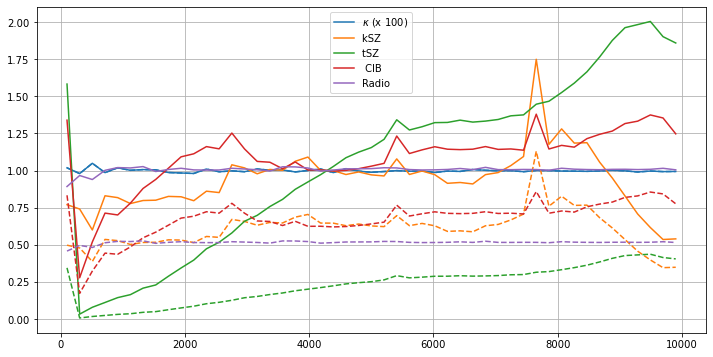

In [72]:
import scipy
    
def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":" CIB ",
               "rad":"Radio",
              }
    return storage[key]
    
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
for key1 in compts:
    #if key1 == "kappa": continue
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key+"_r{}".format(save_points[-1])

    
    
    lbin = STAT_TEST.storage["lbin"][0]
    dlbin_test = STAT_TEST.stats[key]["mean"]
    std_test = STAT_TEST.stats[key]["std"]
    dlbin_gen = STAT_GEN.stats[skey]["mean"]
    std_gen = STAT_GEN.stats[skey]["std"]
    
        
    def f(a, gen_spec=(dlbin_gen,std_gen), ref_spec=(dlbin_test,std_test), lbin=lbin, lmin=4000, lmax=4500):
        gen, std_gen = gen_spec
        ref, std_ref = ref_spec
        loc = ((lbin>=lmin) & (lbin <= lmax))
        #print( np.mean(np.abs((a*gen)/ref)[loc]))
        ret = np.sum((((a*gen-ref)/1)**2)[loc])
        return ret
        #return np.abs(np.mean(((a*gen)/ref-1)[loc]))
    
    ret = scipy.optimize.minimize(f, 1)
    corr = ret["x"][0] if ret["success"] else 1
    print(corr, np.sqrt(corr),ret["success"] )
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(lbin, (corr*dlbin_gen/dlbin_test), label=key2label(key1), color=color)
    plt.plot(lbin, (dlbin_gen/dlbin_test), ls="--", color=color)

plt.yscale("linear")
plt.grid()
plt.legend()
plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

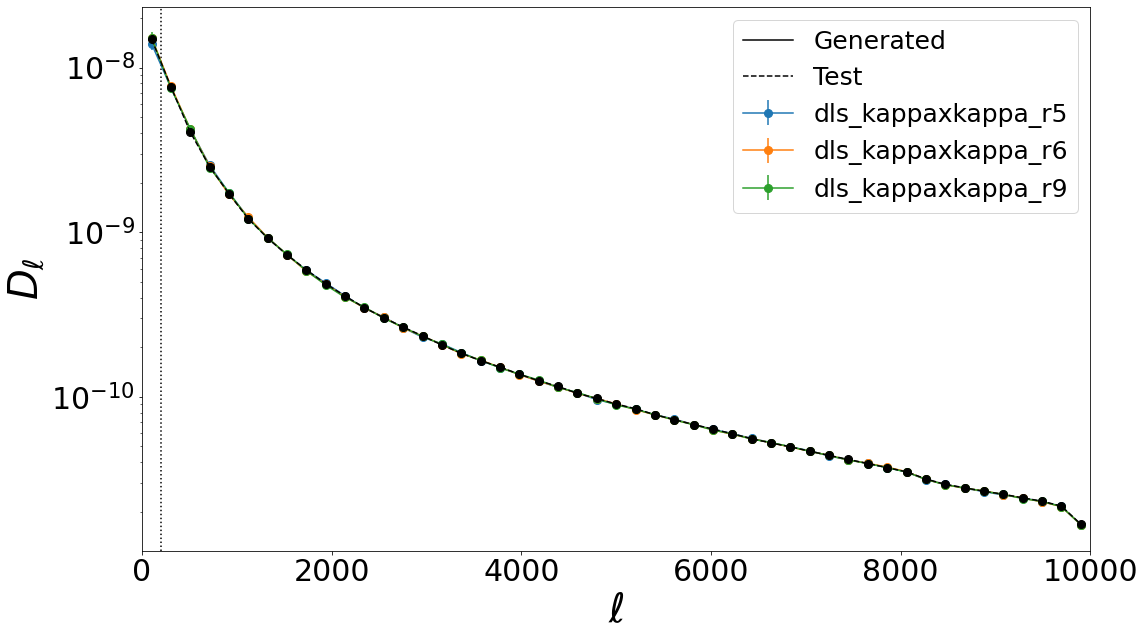

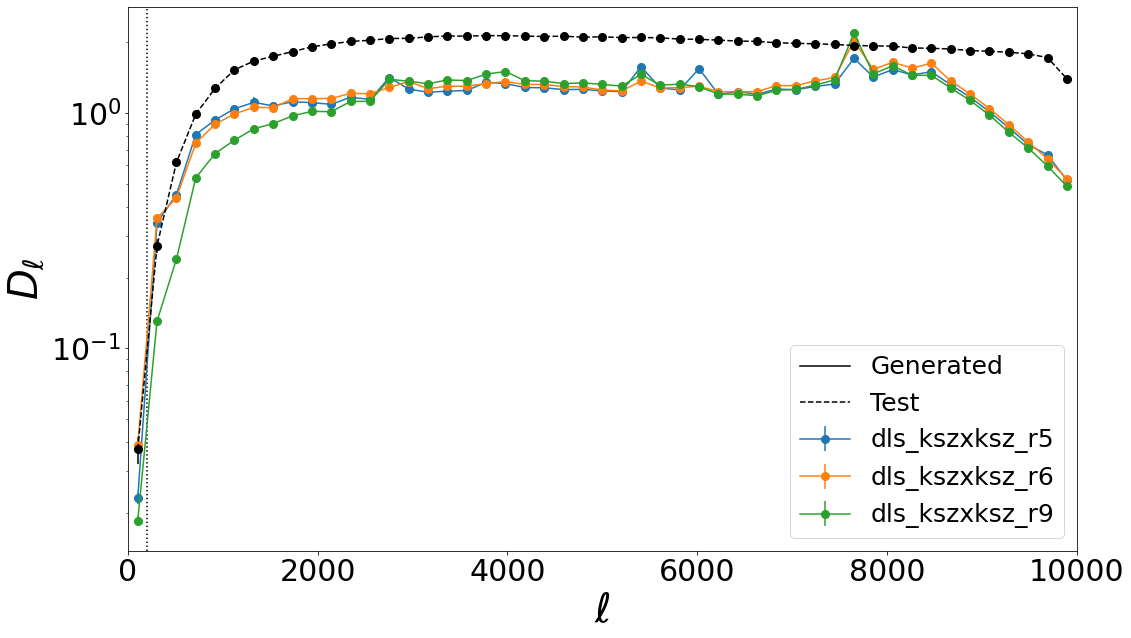

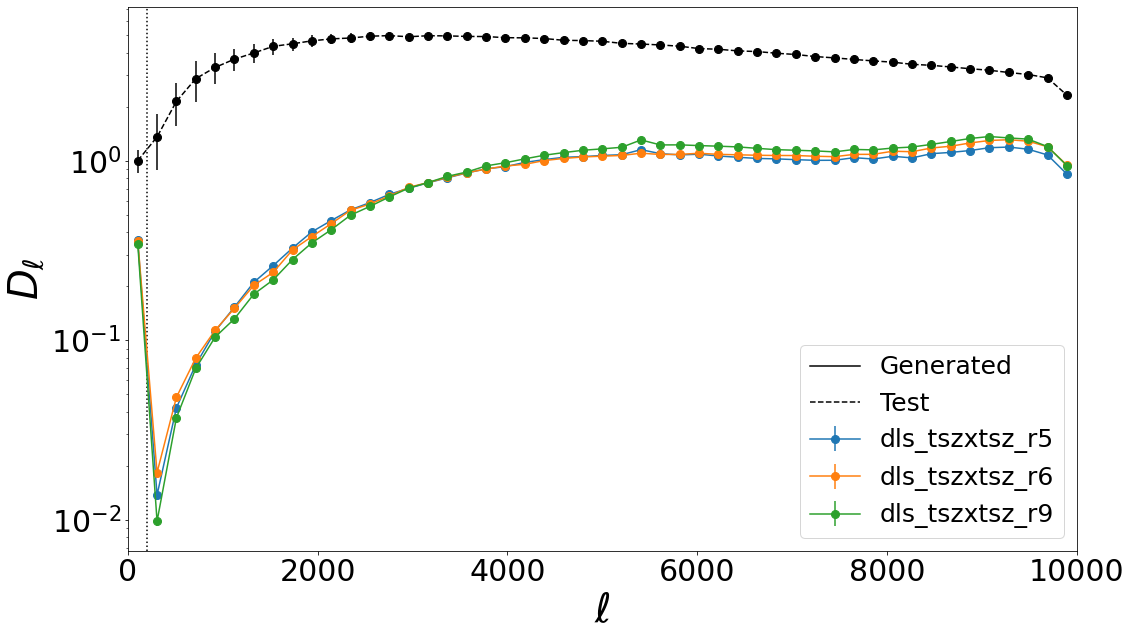

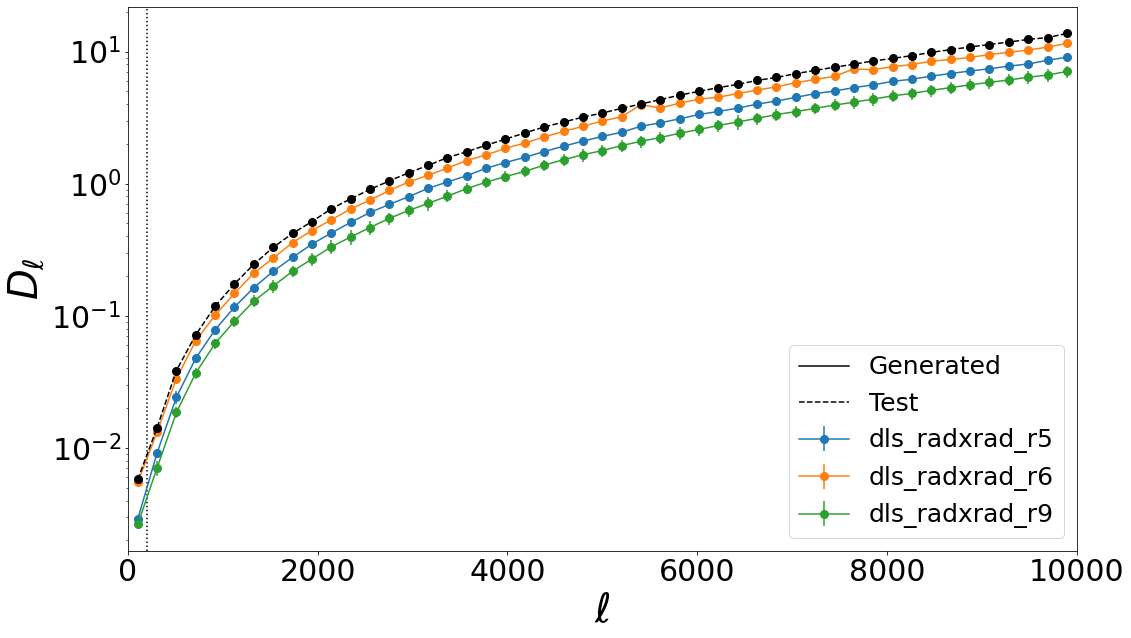

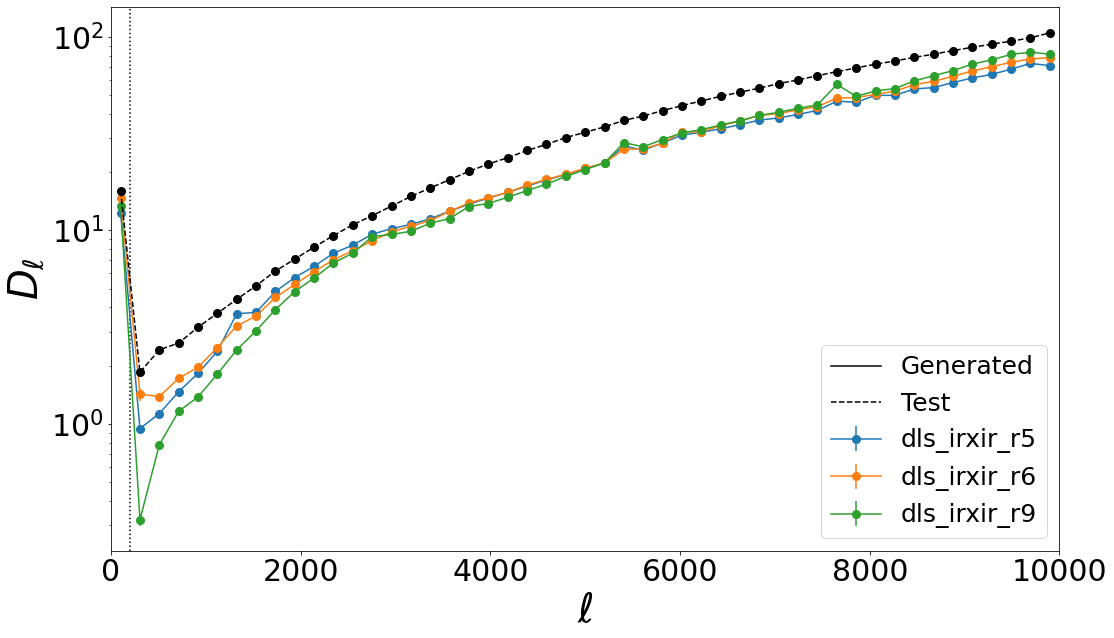

In [73]:
plt.clf()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
   
    mult_fact = 1.2**2 if key1 == "tsza" else 1
    for save_point in save_points[:]:#,20]:
        skey = key + "_r" + str(save_point)
        lbin = STAT_GEN.storage["lbin"][0].copy() 
        dlbin = STAT_GEN.stats[skey]["mean"].copy()*mult_fact
        std = STAT_GEN.stats[skey]["std"].copy()
        if key1 == "kappa":
            dlbin /= lbin**2
            std /= lbin**2
       
        plt.errorbar(lbin, dlbin, std,  marker="o",markersize=8, label=skey)
    #if key1 == "kappa":
    #    clkk_temp =  clkk_bin/lbin**2
    #    plt.plot(lbin,clkk_temp)

    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    if key1 == "kappa":
        dlbin /= lbin**2
        std /= lbin**2
    plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=200, ls=":", color="k")
    plt.xlim(0,10000)
    plt.yscale("log")
    plt.show()

<Figure size 432x288 with 0 Axes>

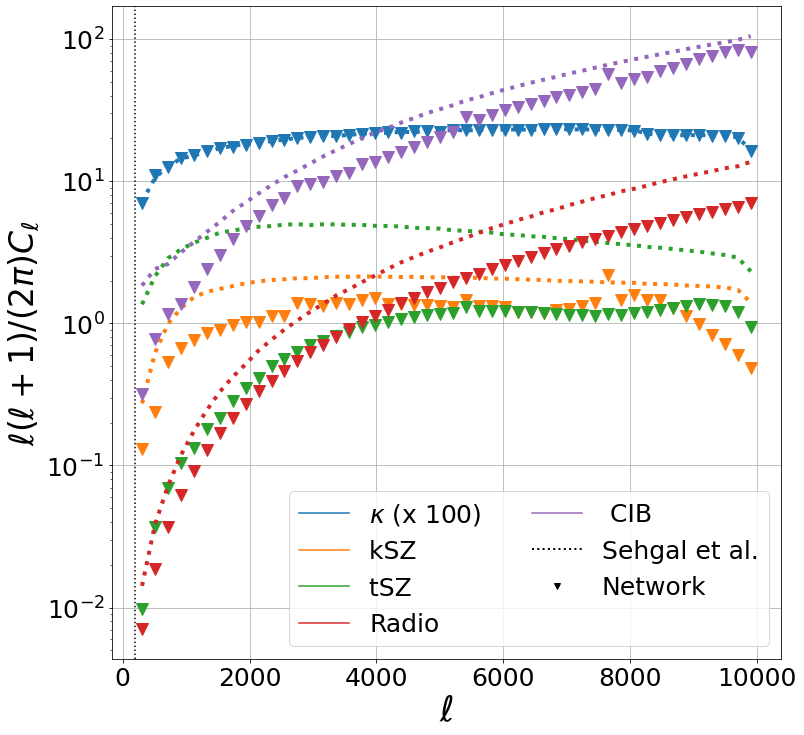

In [74]:
plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()


loc = np.where(lbin>200)
for key1 in compts:
    #if key1 == "kappa": continue
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key+"_r{}".format(save_points[-1])
    multi_fact = 1e4 if key1 == "kappa" else 1
    corr_fact  = 1.2**2 if key1 == "tsza" else 1 
    #multi_fact = 1.2**2 if key1 == "tsz" else 1
 
    color = next(ax._get_lines.prop_cycler)['color']
    
    lbin = STAT_TEST.storage["lbin"][0]#661582ea84424e25bda0534a174d40e4
    dlbin = STAT_TEST.stats[key]["mean"]*multi_fact
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=4, marker="",markersize=8, color=color, ls=":")
    lbin = STAT_GEN.storage["lbin"][0]
    dlbin = STAT_GEN.stats[skey]["mean"]*multi_fact*corr_fact
    plt.plot(lbin[loc], dlbin[loc], alpha=1, lw=2, marker="v",markersize=12, color=color, ls="")
    

    plt.plot([],[], label=key2label(key1), color=color)
plt.plot([],[], lw=2, marker="", label="Sehgal et al.", color="k", ls=":")
plt.plot([],[], lw=2, marker="v", ls="", label="Network", color="k")
ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
ax.set_xlabel(r"$\ell$", fontsize=35)
plt.legend(fontsize=25, ncol=2)



ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.axvline(x=200, ls=":", color="k")
ax.set_yscale("log")
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(plot_path("151020_ps_before_transfer.pdf"), bbox_inches='tight')
plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


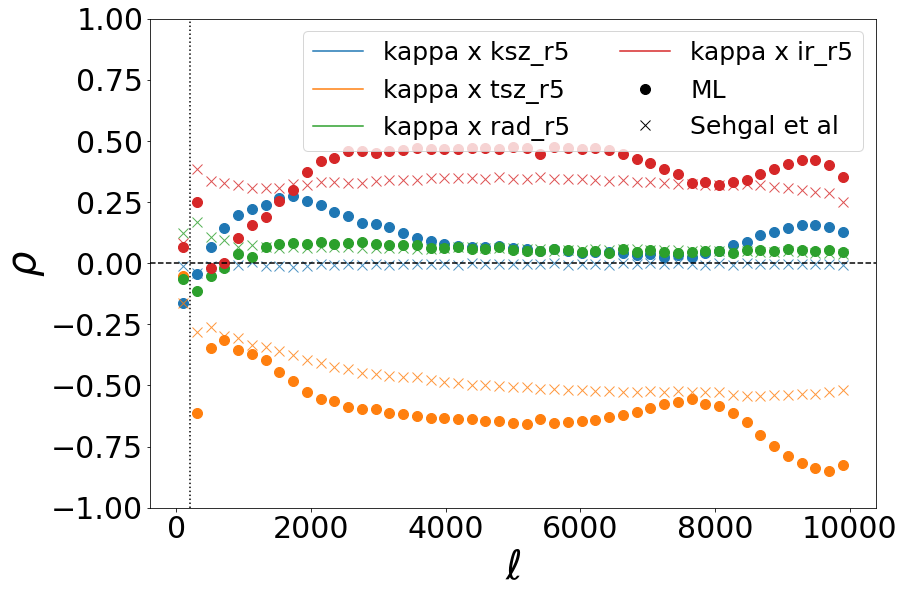

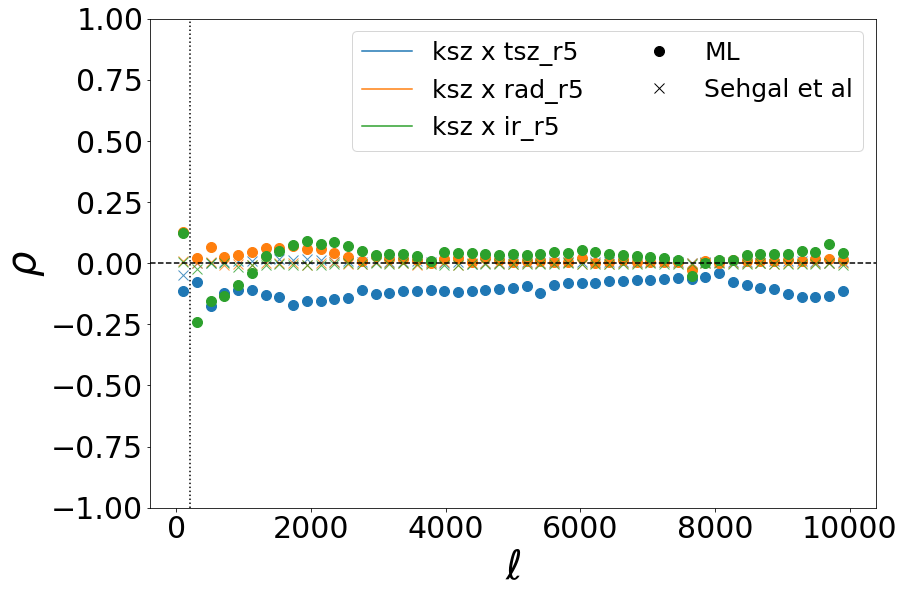

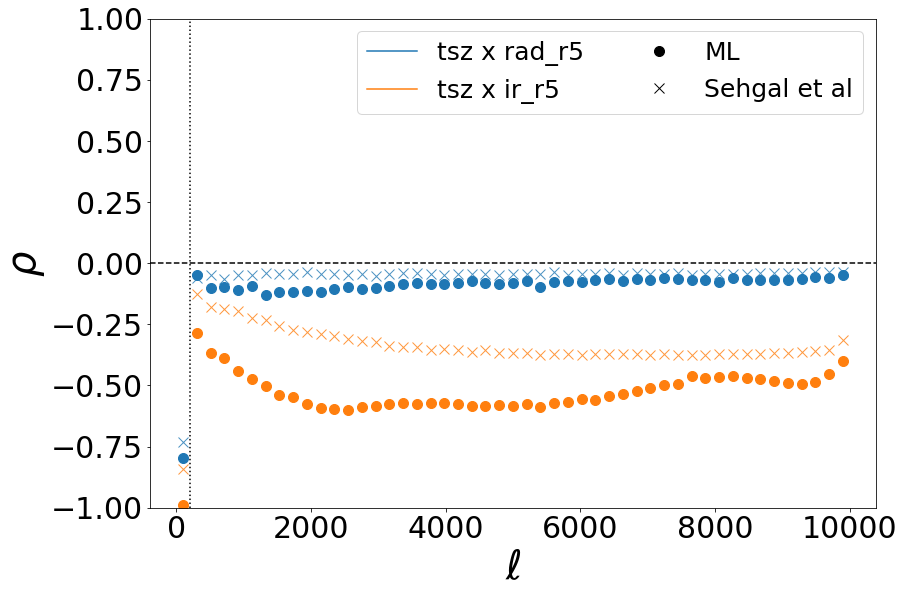

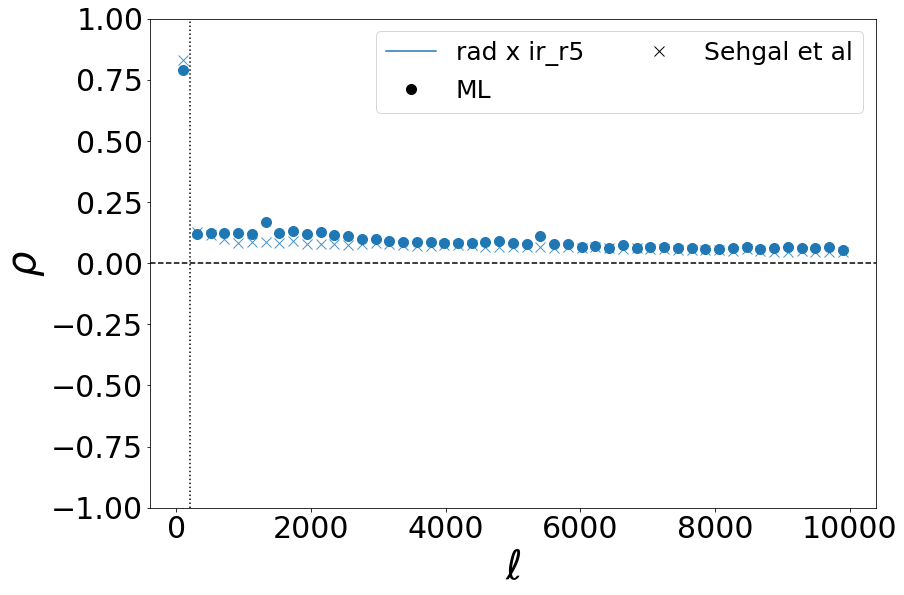

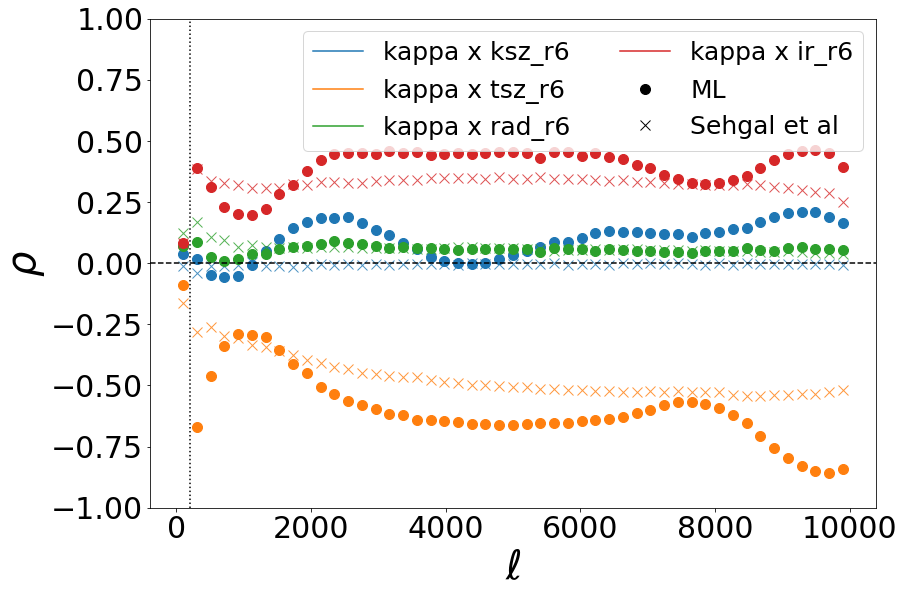

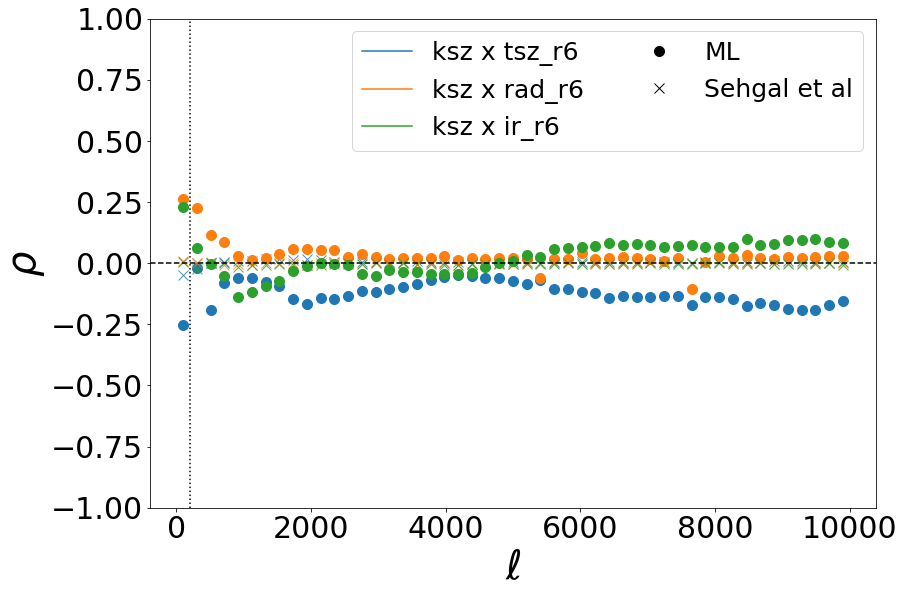

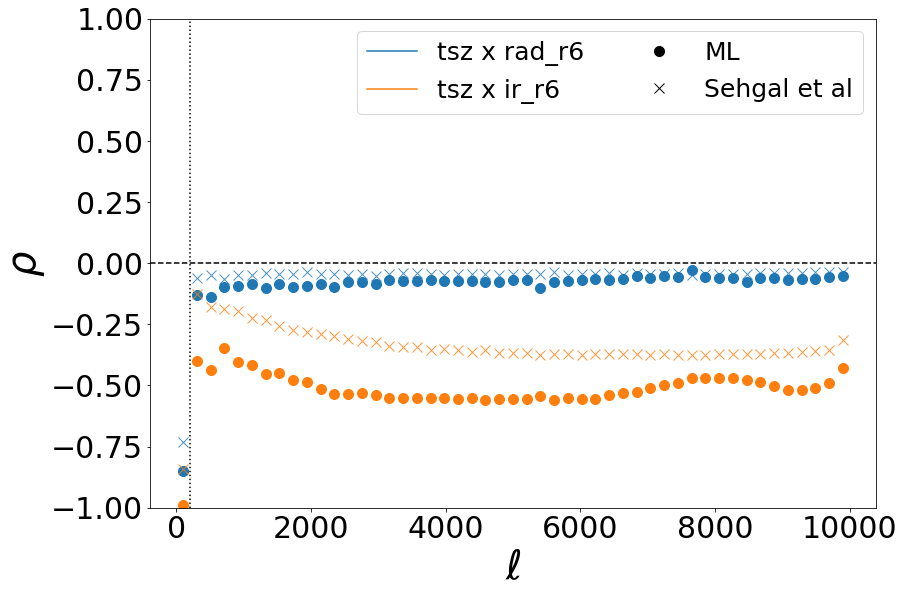

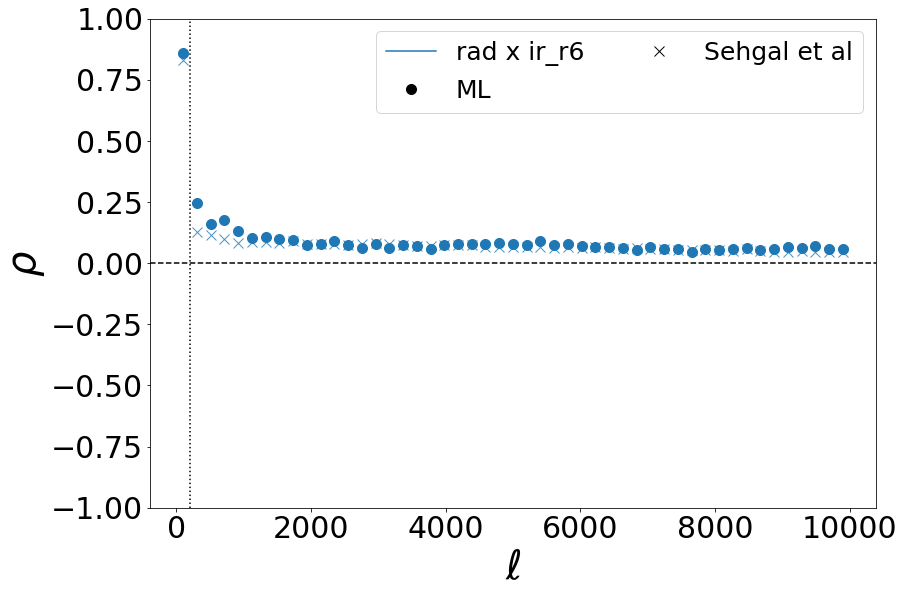

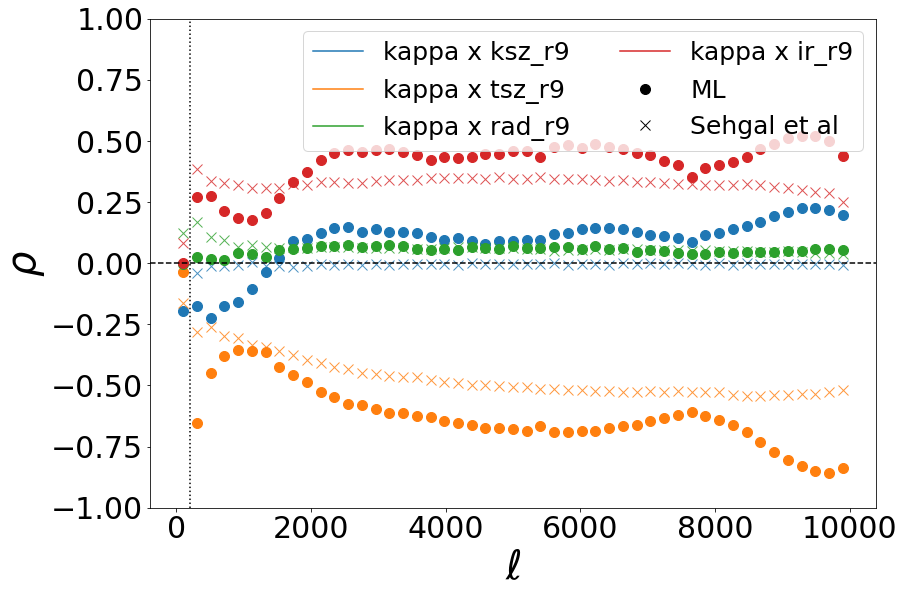

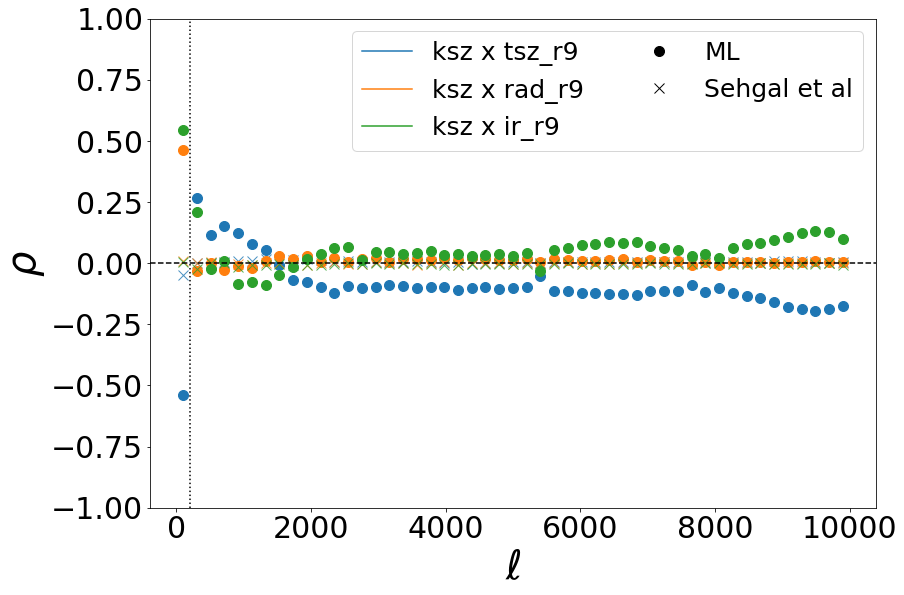

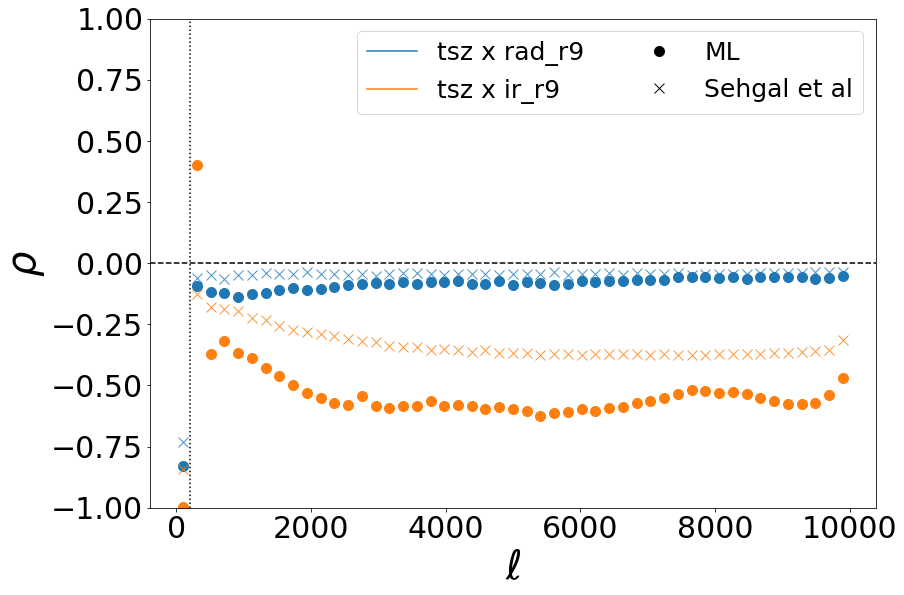

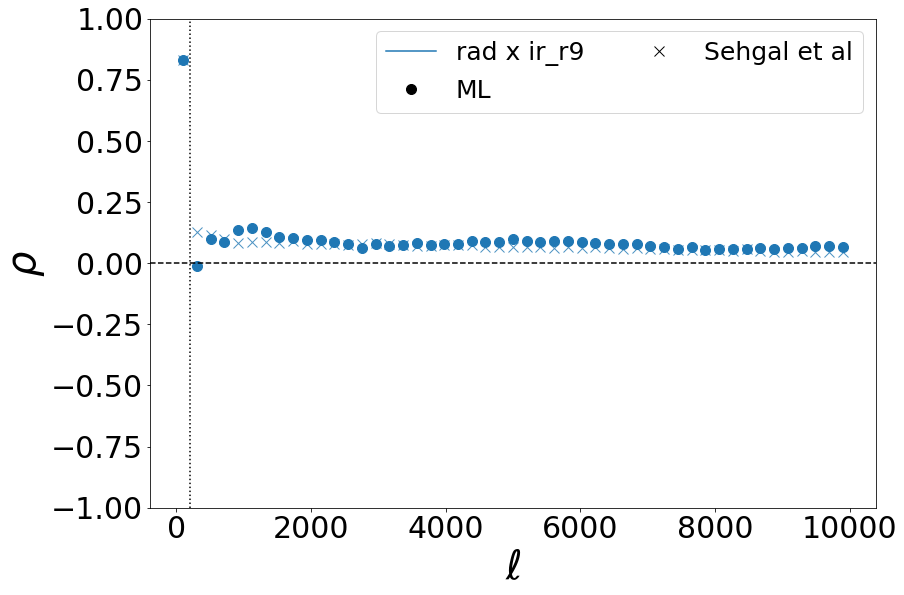

In [75]:
def get_correlation(STAT, key1, key2, postfix=""):
    key1 = compts[i]
    key2 = compts[j]
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)+postfix
    
    dls_x = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key1, key1])+postfix
    dls_1 = STAT.stats[key]["mean"].copy()

    key = "dls_"+"x".join([key2, key2])+postfix
    dls_2 = STAT.stats[key]["mean"].copy()

    return dls_x/np.sqrt(dls_1*dls_2)
    
for save_point in save_points[:]:
    compts = ["kappa", "ksz", "tsz", "rad", "ir"]
    for i in range(5-1):
        fig = plt.figure(figsize=(13,9))
        ax = fig.gca()
        for j in range(i+1,5):
            key1, key2 = compts[i], compts[j]
            lbin = STAT_GEN.storage["lbin"][0]
            color = next(ax._get_lines.prop_cycler)['color']
            rho = get_correlation(STAT_TEST, key1, key2)
            plt.plot(lbin, rho, alpha=0.8,  ls="", marker="x", markersize=10, color=color)

            rho = get_correlation(STAT_GEN, key1, key2, "_r{}".format(save_point))
            plt.plot(lbin, rho, alpha=1,  ls="", marker="o", markersize=10, color=color)
            plt.plot([],[], label="{}".format(" x ".join([key1, key2]) +"_r{}".format(save_point)), color=color)
        plt.plot([],[], ls="",label="ML", color="k",  marker="o", markersize=10)
        plt.plot([],[], ls="",label="Sehgal et al", color="k",  marker="x", markersize=10)

        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.tick_params(axis='both', which='minor', labelsize=30)
        plt.ylabel(r"$\rho$", fontsize=40)
        plt.xlabel(r"$\ell$", fontsize=40)
        plt.ylim(-1,1)
        plt.axvline(x=200, ls=":", color="k")
        plt.axhline(y=0, ls="--", color="k")
        plt.legend(fontsize=25, loc="upper right", ncol=2)
        plt.show()


In [13]:
STAT_GEN_CORR = stats.STATS("sehgal_cosmoganwTruegpv6_gen_corr", output_dir=stat_dir, overwrite=True)
for st_key in STAT_GEN.storage:
    if st_key == "lbin": 
        STAT_GEN_CORR.add_data("lbin", 0, STAT_GEN.storage["lbin"][0])
        continue
    ost_key = "_".join(st_key.split("_")[:2])
    nst_key = st_key 
    transf = STAT_TEST.stats[ost_key]["mean"]/STAT_GEN.stats[st_key]["mean"]
    for sim_idx in STAT_GEN.storage[st_key]:
        STAT_GEN_CORR.add_data(nst_key, sim_idx, STAT_GEN.storage[st_key][sim_idx]*transf)
        
STAT_GEN_CORR.get_stats(save_data=False)

        

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dwhan89/workspace/cosmikyu/cosmikyu/stats.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(data.transpose(), ddof=ddof)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/dwhan89/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
calculating stats


{'lbin': {'mean': array([ 103. ,  306.5,  510.5,  714.5,  918.5, 1122.5, 1326.5, 1530.5,
         1734.5, 1938.5, 2142.5, 2346.5, 2551. , 2755.5, 2959.5, 3163.5,
         3367.5, 3571.5, 3775.5, 3979.5, 4183.5, 4387.5, 4591.5, 4795.5,
         5000. , 5204.5, 5408.5, 5612.5, 5816.5, 6020.5, 6224.5, 6428.5,
         6632.5, 6836.5, 7040.5, 7244.5, 7449. , 7653.5, 7857.5, 8061.5,
         8265.5, 8469.5, 8673.5, 8877.5, 9081.5, 9285.5, 9489.5, 9693.5,
         9898. ]),
  'cov': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'corrcoef': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

<Figure size 432x288 with 0 Axes>

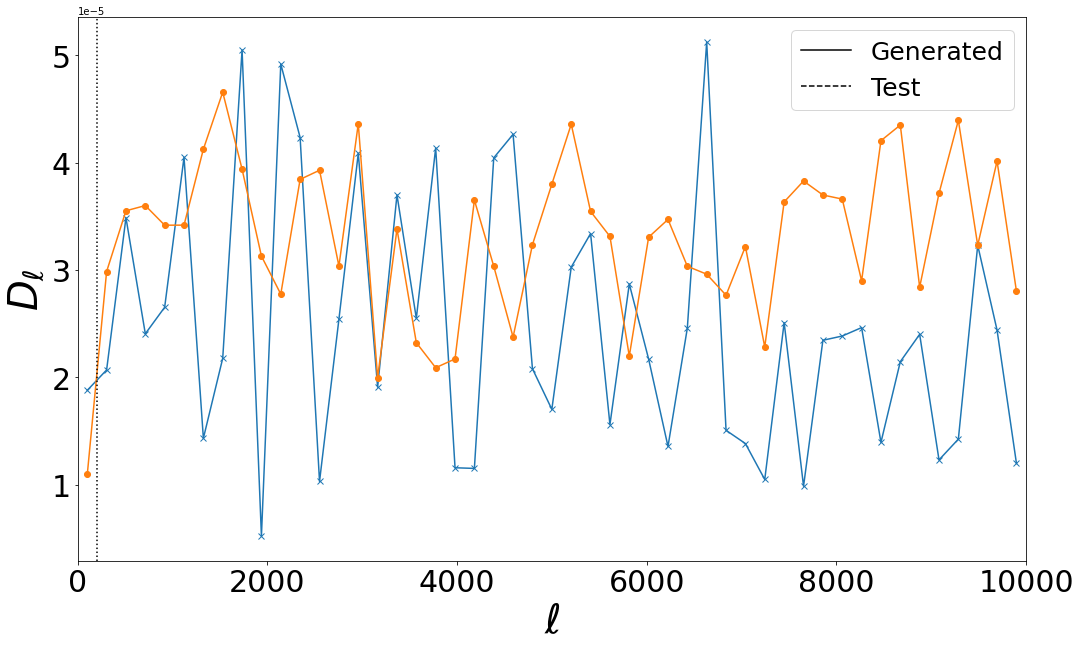

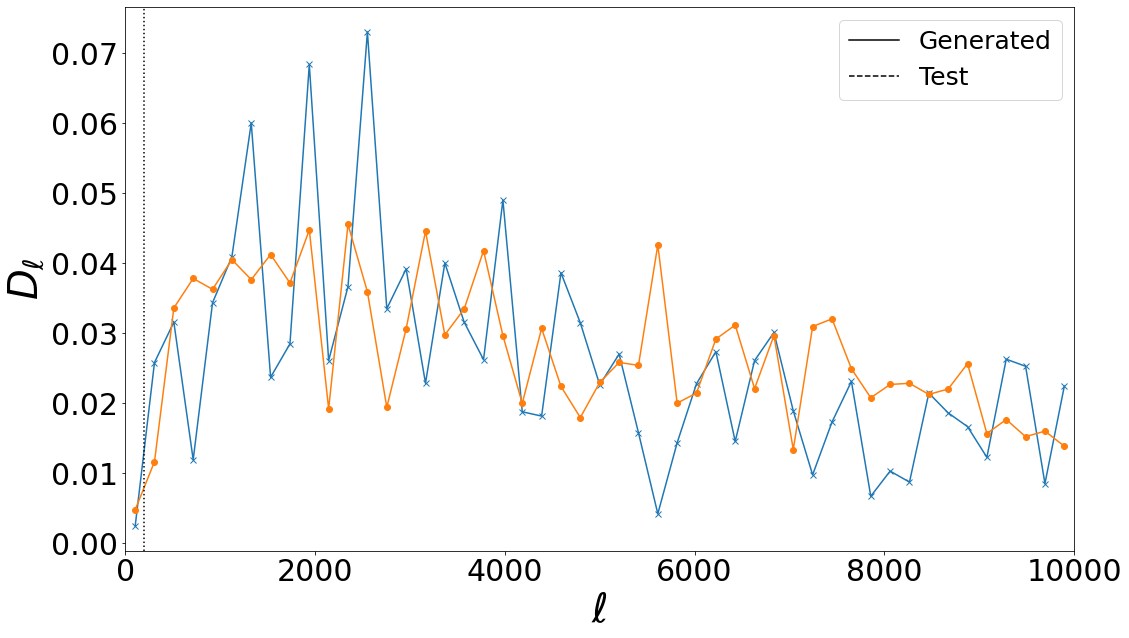

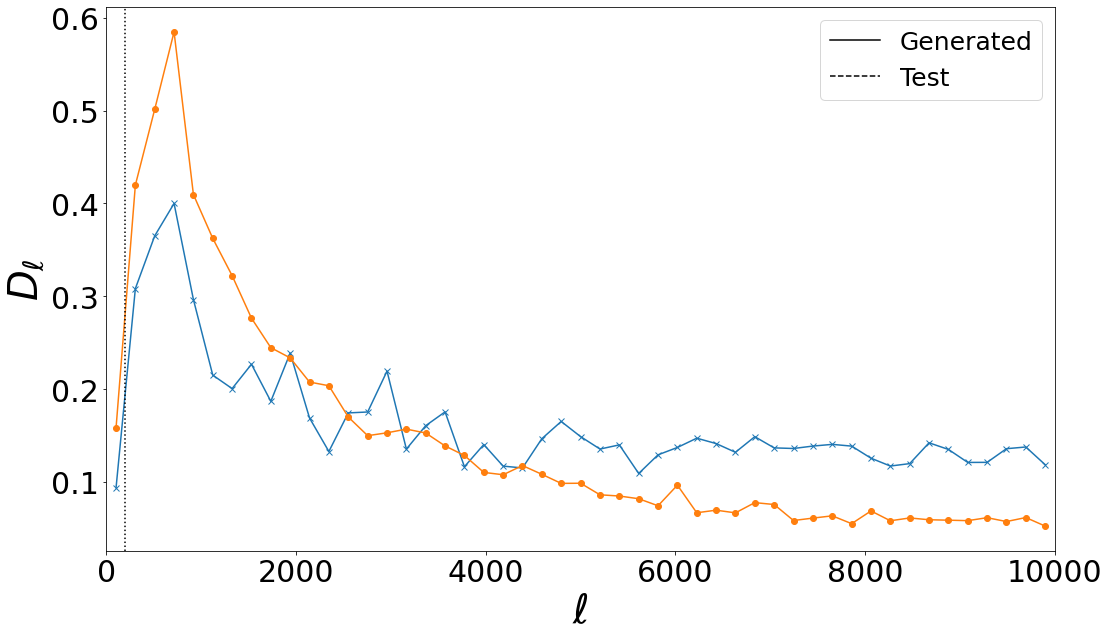

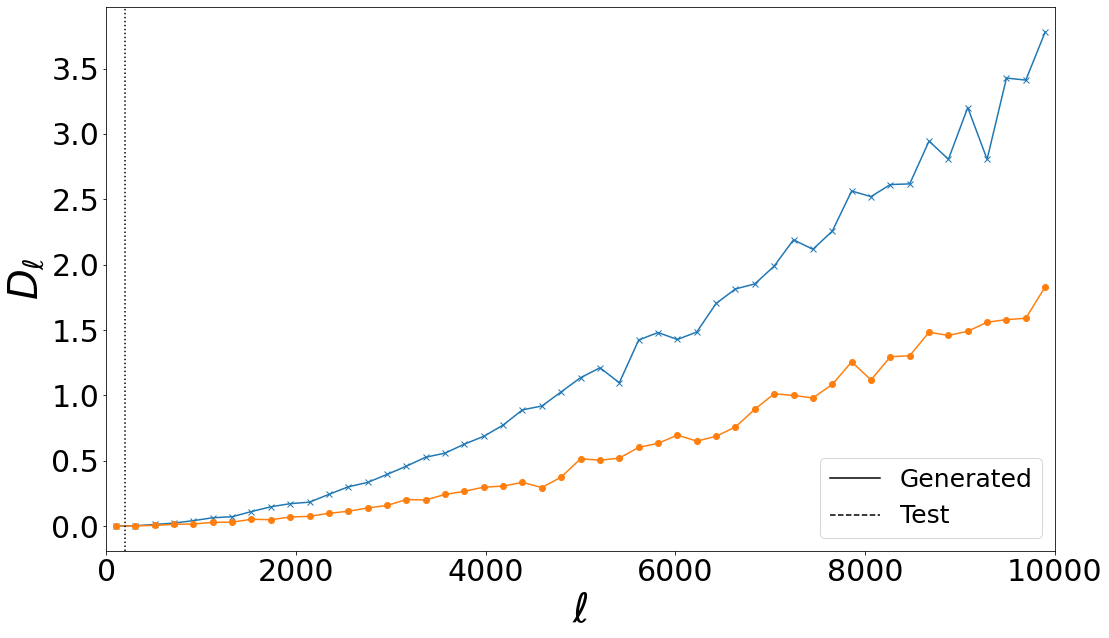

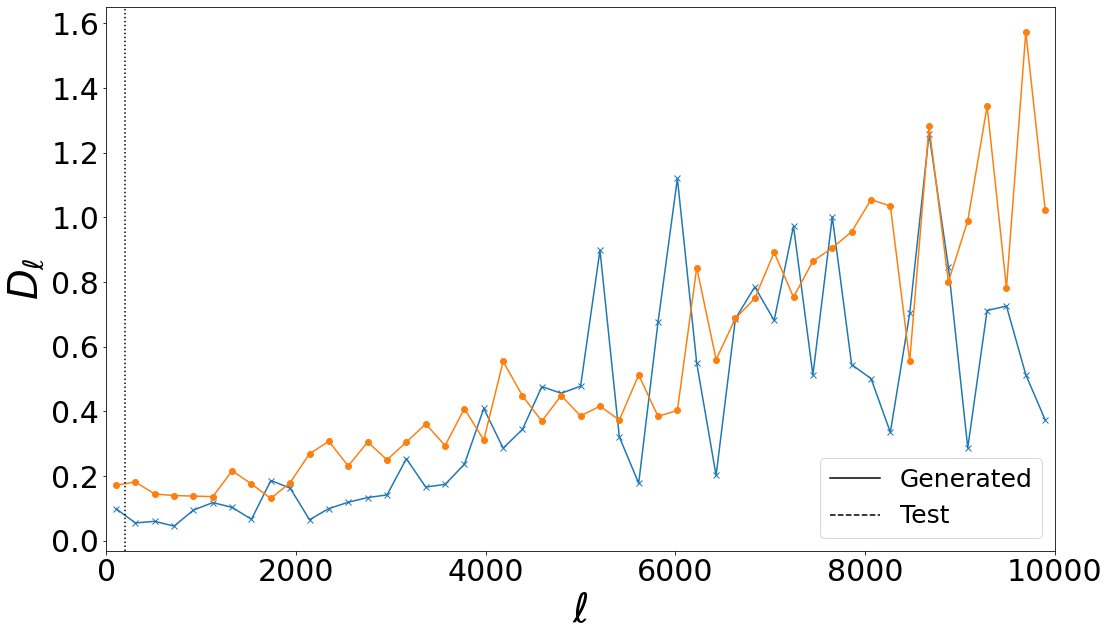

In [14]:

plt.clf()
compts = ["kappa", "ksz", "tsz", "rad", "ir"]
for key1 in compts:
    fig = plt.figure(figsize=(17,10))
    ax = fig.gca()
    key2 = key1
    key = [key1, key2]
    key.sort()
    key = "dls_"+"x".join(key)
    skey = key + "_r" + str(save_points[0])

    dlbin_gen = STAT_GEN_CORR.stats[skey]["mean"].copy()
    std_gen = STAT_GEN_CORR.stats[skey]["std"].copy()
    
    lbin = STAT_TEST.storage["lbin"][0].copy()
    dlbin = STAT_TEST.stats[key]["mean"].copy()
    std = STAT_TEST.stats[key]["std"].copy()
    #plt.plot(lbin,(dlbin/dlbin_gen), marker="*")
    #plt.plot(lbin, std_gen/std*(dlbin/dlbin_gen), marker="o")
    plt.plot(lbin, std_gen, marker="x")
    plt.plot(lbin, std, marker="o")
    #plt.errorbar(lbin, dlbin, std, marker="o",markersize=8, color="k", ls="--")
    #plt.plot(l, dls, alpha=0.3, label=key, ls="", marker="o", markersize=4)
    #plt.plot([],[], label=key, color=color)
    plt.plot([],[], ls="-",label="Generated", color="k")
    plt.plot([],[], ls="--",label="Test", color="k")
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.ylabel(r"$D_\ell$", fontsize=40)
    plt.xlabel(r"$\ell$", fontsize=40)
    plt.legend(fontsize=25)
    #plt.ylim(1e-7,2e3)
    plt.axvline(x=200, ls=":", color="k")
    plt.xlim(0,10000)
    #plt.yscale("log")
    plt.show()